# Analyze A/B Test Results 

statistical subjects applied in this project: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I'll be working to understand the results of an A/B test run by an e-commerce website.  the goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

import the necessary libraries:

In [58]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file :

In [59]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** the number of rows in the dataset.

In [60]:
len(df)

294478

**c.** The number of unique users in the dataset.

In [61]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [62]:
converted = df[df['converted'] == 1]['converted'].count()
print(converted/df.shape[0])

0.11965919355605512


**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [63]:
df.loc[(df['group']=='treatment') & (df['landing_page'] != 'new_page')]

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0
...,...,...,...,...,...
293773,688144,2017-01-16 20:34:50.450528,treatment,old_page,1
293817,876037,2017-01-17 16:15:08.957152,treatment,old_page,1
293917,738357,2017-01-05 15:37:55.729133,treatment,old_page,0
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0


**f.** Checking if any of the rows have missing values.

In [64]:
df[df.isna().any(axis=1)]

,user_id,timestamp,group,landing_page,converted


>**<span style="color: blue;">no missing values.**</span>


In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


in this case we drop the rows with unmatched `landing_page` and `group` 

**a.** Remove the inaccurate rows, and store the result in a new dataframe `df2`.

In [65]:
df2=df.loc[(df['group']=='treatment') & (df['landing_page'] == 'new_page')|(df['group']=='control') & (df['landing_page'] == 'old_page')]

In [66]:
# check if the rows are dropped
df2.loc[(df['group']=='treatment') & (df['landing_page'] != 'new_page')]
df2.loc[(df['group']=='control') & (df['landing_page'] != 'old_page')]

,user_id,timestamp,group,landing_page,converted


In [67]:
# Double Check all of the incorrect rows were removed from df2
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [68]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [69]:
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [70]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [71]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop_duplicates(['user_id'])
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted


**a.** What is the probability of an individual converting regardless of the page they receive?

In [72]:
population = df2[df2['converted']==1]['user_id'].nunique()
print(population/df2.shape[0])

0.11959708724499628


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [73]:
control_df = df2.query("group == 'control'")

In [74]:
control_conv = (control_df.loc[control_df['converted']==1]['user_id'].nunique())/(control_df.shape[0])
control_conv

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [75]:
treatment_df = df2.query("group == 'treatment'")

In [76]:
treatment_conv = (treatment_df.loc[treatment_df['converted'] == 1]['user_id'].nunique())/(treatment_df.shape[0])
treatment_conv

0.11880806551510564

Now, calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. as it will be needed later

In [77]:
obs_diff = control_conv - treatment_conv
obs_diff

0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [78]:
recieved_new = (treatment_df['user_id'].nunique())/(df2.shape[0])
recieved_new

0.5000619442226688

In [79]:
recieved_old = (control_df['user_id'].nunique())/(df2.shape[0])
recieved_old

0.4999380557773312

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

><span style="color: blue;">**there are no evidence that the treatment group lead to more conversions.**</span>

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  



For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page .

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>
><center>
>H0: 𝑝𝑜𝑙𝑑≤𝑝𝑛𝑒𝑤<br>
>H1: 𝑝𝑛𝑒𝑤>𝑝𝑜𝑙𝑑
                           ></center>
  

## Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [80]:
p_new_rate = df2['converted'].mean()
p_new_rate

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [81]:
p_old_rate = df2['converted'].mean()
p_old_rate

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [82]:
n_new = treatment_df.shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [83]:
n_old = control_df.shape[0]
n_old

145274

In [84]:
obs_diff = p_old_rate - p_new_rate
obs_diff

0.0

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  

In [85]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1,0],n_new , p=(p_new_rate,1-p_new_rate))
new_page_converted.mean()

0.11873924712683229

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [86]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1,0],n_old , p=(p_old_rate , 1-p_old_rate))
old_page_converted.mean()

0.11929182097278247

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [87]:
print(new_page_converted.mean() - old_page_converted.mean())

-0.0005525738459501855



**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [88]:
# Sampling distribution 
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([1,0],n_new,replace=True , p=(p_new_rate,1-p_new_rate))
    old_page_converted = np.random.choice([1,0],n_old,replace=True , p=(p_old_rate , 1-p_old_rate))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**. <br><br>

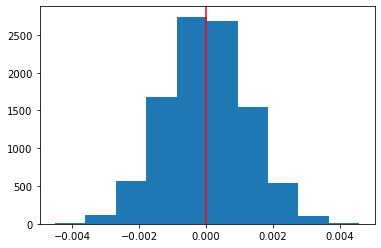

In [89]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff , color='red');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [90]:
obs_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
print(obs_diff)
p_diffs = np.array(p_diffs)
(obs_diff < p_diffs).mean()

-0.0015782389853555567


0.9009

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

><span style="color: blue;">in part j we have computed p-value <br>
>and in this case it fails to reject the null<br>
>since `p-value` > `Type I error`</span>



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 


- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [91]:
import statsmodels.api as sm


convert_old = df2.query(" landing_page == 'old_page' & converted == '1' ")['user_id'].nunique()


convert_new =df2.query(" landing_page == 'new_page' & converted == '1' ")['user_id'].nunique()


n_old = df2.query( "landing_page == 'old_page'")['user_id'].nunique()


n_new = df2.query( "landing_page == 'new_page'")['user_id'].nunique()

**m.** Now use `sm.stats.proportions_ztest()` to compute the test statistic and p-value. 



>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.





In [92]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

> <span style="color: blue;">**no, but its still greater than the type I error which fails to reject the null.**</span>

<a id='regression'></a>
### Part III - A regression approach

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

><span style="color: blue;">**logistic regression**</span>

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [93]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [94]:
model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [95]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2023-04-27 01:24 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

><span style="color: blue;">**Null & alternative hypotheses:**<br></span>
><span style="color: blue;">**<center>H0 = 0<br> 
>H1 ≠ 0</center><br></span>
><span style="color: blue;">the hypothesis here are two-sided unlike part II where the hypothesis were one-sided**<br></span>
><span style="color: blue;"> `p-value` > `α`<br></span>
><span style="color: blue;">**therefore, fails to reject the null** <br></span>

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<span style="color: blue;">**additional factors should be added, disadvantages depends on the factors added and how it will influence the results.**</span>

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

In [96]:
# Read the countries.csv
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [97]:
# Join with the df2 dataframe
df_merged = df2.join(countries_df['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK


In [98]:
# Create the necessary dummy variables
df_merged[['UK','US','CA']] = pd.get_dummies(df_merged['country'])
df_merged = df_merged.drop(['CA'],axis=1)
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK,0,1


In [110]:
model2 = sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','UK','US']])
result=model2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 29 Apr 2023   Pseudo R-squ.:               1.420e-05
Time:                        06:04:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3884
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9891      0.009   -224.021      0.000      -2.007      -1.972
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
UK            -0.0258      0.027     -0.959      0.338      -0.078       0.027
US             0.0065      0.013      0.485      0.628      -0.020       0.033
==============================================================================
"""

In [111]:
print(1/np.exp(-0.0258))
print(np.exp(0.0065))

1.026135700809198
1.0065211708453077


><span style="color: blue;">**-When users are in the US they are <span style="color: red;">(1.006)</span> more likely to convert than if they >were living in canada, holding all other variables constant.<br>
>-When users are in the UK they are <span style="color: red;">(1.03)</span> more likely to convert than if they >were living in canada, holding all other variables constant.**</span>

**h. Fit the model and obtain the results**<br> 
now look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 

In [99]:
#adding higher order terms (ab_page with UK and US interaction)
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_US'] = df_merged['ab_page'] * df_merged['US']
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,ab_UK,ab_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK,0,1,0,0


In [108]:
# Fit your model, and summarize the results
model3 = sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','UK','US','ab_UK','ab_US']])
result=model3.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 29 Apr 2023   Pseudo R-squ.:               2.544e-05
Time:                        06:03:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3675
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9859      0.010   -206.792      0.000      -2.005      -1.967
ab_page       -0.0215      0.014     -1.582      0.114      -0.048       0.005
UK            -0.0675      0.039     -1.753      0.080      -0.143       0.008
US             0.0013      0.019      0.067      0.947      -0.036       0.038
ab_UK          0.0825      0.054      1.534      0.125      -0.023       0.188
ab_US          0.0105      0.027      0.394      0.694      -0.042       0.063
==============================================================================
"""

In [112]:
print(np.exp(0.0825))
print(np.exp(0.0105))

1.0859986734390565
1.0105553184450264


<h3>Conclusion:</h3>

><span style="color: blue;">-For when a user is in the US we expect a multiplicative change in the odds of the conversions by <span style="color: red;">(1.01)</span> compared to baseline (users in CA)<br>
    >-On the other hand, when users are in the UK they are <span style="color: red;">(1.08)</span> more likely to convert than if they were living in canada, holding all other variables constant.<br>
>-all the variables are not statistically significant.<br></span>

><span style="color: blue;">**to conclude, we don't have enough evidence that the new page results in more conversions than the old page
>therefore, i suggest keeping the old page .**</span>